# Hierarchical Forecasting   
  
What It Is   
	•	Hierarchical forecasting aggregates data at higher levels (e.g., brand level or total sales) to compensate for sparsity at lower levels (e.g., brand + family).   
	•	Predictions are made at the higher levels and disaggregated down to smaller groups (e.g., brand-family) using proportions.   
  
Steps to Implement   
	1.	Aggregate to Higher Levels:   
	•	Aggregate sparse brand-family data up to broader levels:   
	•	Brand level: brand_total_sales  
	•	Family level: family_total_sales  
	•	Overall total: global_total_sales  
	•	Use the aggregated time series to train the model.  
	2.	Forecast at Higher Levels:   
	•	Predict sales at the aggregated levels using richer historical data.  
	3.	Disaggregate Forecasts:  
	•	Split the higher-level forecasts back down to the brand-family level using historical proportions. For example:
$\text{brand\_family\_forecast} = \text{brand\_forecast} \times \frac{\text{brand\_family\_sales}}{\text{brand\_total\_sales}}$  
	4.	Smooth Proportions for Stability:  
	•	Use smoothed historical proportions (e.g., rolling averages) to prevent overfitting to noisy historical proportions.  



Steps in the Implementation  
	1.	Aggregate Sparse Data to Higher Levels (e.g., brand).    
	2.	Train a Forecasting Model at the Higher Level (e.g., using a simple statistical model or machine learning).    
	3.	Disaggregate Forecasts:    
	•	Use historical proportions to split higher-level forecasts back down to the brand + family level.  

In [1]:
import pandas as pd
import utils.utils_models as utils_models

import utils.utils_preprocessing as utils_preprocessing
import utils.utils_features as utils_features

In [2]:
df_sales = pd.read_parquet("data/sales.parquet")
df_products = pd.read_parquet("data/products.parquet")
df = df_sales.merge(df_products, on="product_id")

In [3]:
df = utils_preprocessing.set_types(df)
df = utils_preprocessing.filter_dates(df, date="2024-09-01")

df_monthly = utils_preprocessing.aggregate_data(
    df, 
    frequency="ME"
    )
df_monthly = utils_preprocessing.fill_in_missing_dates(
    df_monthly, 
    group_col=["brand", "family"], 
    date_col="date", 
    freq="ME"
    )
df_monthly = utils_features.features_time_related(
    df_monthly, 
    frequency='ME'
    )

In [4]:
train_end_date = df_monthly['date'].max() - pd.DateOffset(months=12)

train_data = df_monthly[df_monthly['date'] <= train_end_date]
test_data = df_monthly[df_monthly['date'] > train_end_date]
X_train, X_test, y_train, y_test = utils_preprocessing.train_test_split(df_monthly, forecasting_horizon=12, target_col="total_revenue")

In [9]:
hyperparameters = {
    "trend": "mul",           
    "seasonal": "mul",       
    "seasonal_periods": 12, 
    "steps_ahead": 12, 
}

exp_smoothing_model = utils_models.HierarchicalModel(forecasting_model="ExponentialSmoothing", hyperparameters=hyperparameters)
exp_smoothing_model.train(X_train=train_data, y_train=None)

/Users/matteogiaretti/Python/use_case_deporvillage/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/matteogiaretti/Python/use_case_deporvillage/.venv/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


,date,forecast_total_revenue,month,total_revenue_agg
0,2023-09-30,80812.902882,9,87625.171875
1,2023-10-31,81136.501979,10,117640.757812
2,2023-11-30,143901.406795,11,138087.468750
3,2023-12-31,148323.792586,12,153979.578125
4,2024-01-31,146305.223404,1,150035.640625
5,2024-02-29,110954.144258,2,116420.750000
6,2024-03-31,131544.839482,3,151570.109375
7,2024-04-30,135600.928491,4,152115.078125
8,2024-05-31,131699.437434,5,146470.390625
9,2024-06-30,112841.826777,6,126623.593750


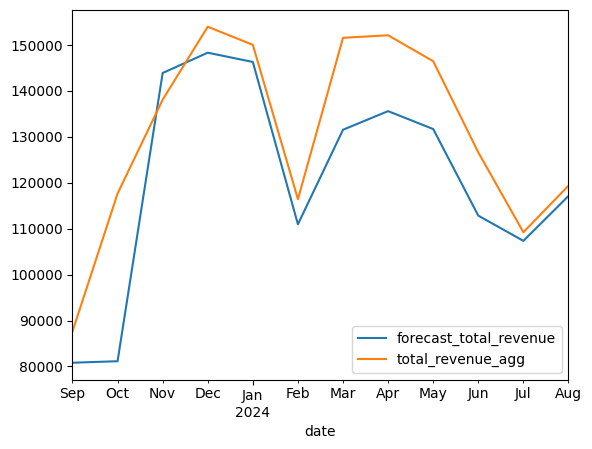

In [10]:
exp_smoothing_model.evaluate_agg_forecast(test_data)

In [11]:
# Predict with aggregated data (SARIMA)

hyperparameters = {
    "order": (1, 1, 1),            
    "seasonal_order": (1, 1, 1, 12),  
    "steps_ahead": 12       
}
sarima_model = utils_models.HierarchicalModel(forecasting_model="Sarima", hyperparameters=hyperparameters)
sarima_model.train(X_train=train_data, y_train=None)

/Users/matteogiaretti/Python/use_case_deporvillage/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/matteogiaretti/Python/use_case_deporvillage/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/matteogiaretti/Python/use_case_deporvillage/.venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


,date,forecast_total_revenue,month,total_revenue_agg
0,2023-09-30,80007.228973,9,87625.171875
1,2023-10-31,78007.842938,10,117640.757812
2,2023-11-30,129691.418471,11,138087.468750
3,2023-12-31,129367.894551,12,153979.578125
4,2024-01-31,124284.653645,1,150035.640625
5,2024-02-29,92738.672638,2,116420.750000
6,2024-03-31,101125.509845,3,151570.109375
7,2024-04-30,99445.591570,4,152115.078125
8,2024-05-31,97812.680040,5,146470.390625
9,2024-06-30,80088.513722,6,126623.593750


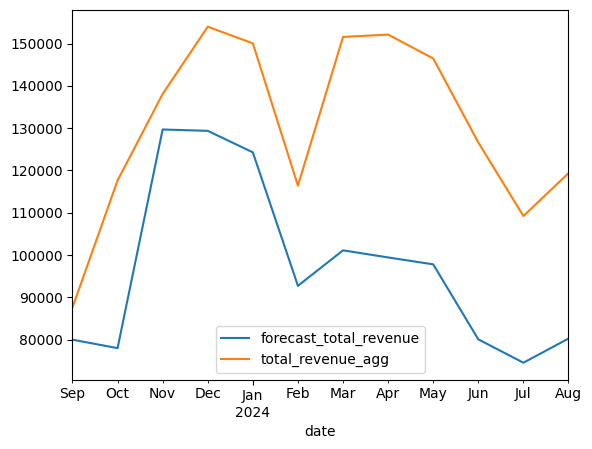

In [12]:
sarima_model.evaluate_agg_forecast(test_data)

In [13]:
df_predictions = sarima_model.predict(X_test)

In [14]:
df_predictions

,date,brand,family,forecast_revenue
0,2023-09-30,adidas,Chanclas Urban,152.105155
1,2023-09-30,adidas,Camisetas Outdoor,233.540272
2,2023-09-30,Columbia,Calzado Après-Ski,133.799250
3,2023-09-30,Columbia,Headwear Outdoor,298.590295
4,2023-09-30,Columbia,Zapatillas de montaña,260.710058
...,...,...,...,...
872,2024-08-31,adidas,Zapatillas Trail Running,8196.463470
873,2024-08-31,adidas,Outlet Zapatillas Running,217.432726
874,2024-08-31,Columbia,Headwear Outdoor,599.486489
875,2024-08-31,adidas,Chanclas Urban,563.625997


In [15]:
actual_vs_forecast = pd.merge(test_data[['date', 'brand', 'family', 'total_revenue']], df_predictions, on=['date', 'brand', 'family'], how='left')


<Axes: >

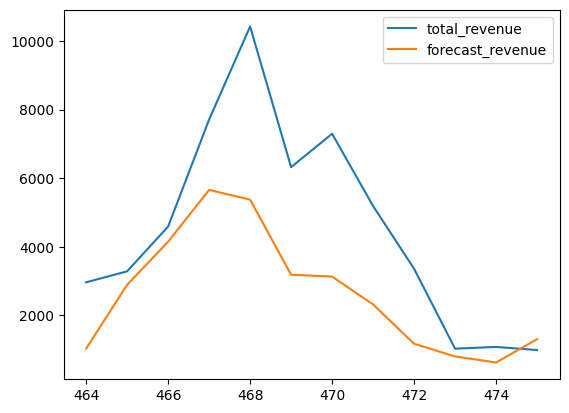

In [16]:
family = "Chándales Urban"
brand = "adidas"
actual_vs_forecast[(actual_vs_forecast["family"] == family) & (actual_vs_forecast["brand"] == brand)][["total_revenue", "forecast_revenue"]].plot()